In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import scipy
import scipy.optimize

import trfp

Welcome to JupyROOT 6.12/04


In [2]:
# Plotting parameters (maybe define standard functions based on these reqs later?)

matplotlib.rc('xtick', labelsize=8)     
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
sns.set(style="darkgrid")

single_column_small = (6.202, 3.833)  #inches
single_column_med = (6.202, 6.202)
single_column_large = (6.202, 7.666)

def plt_unix_time_to_CST(ax):
    plt.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                          for tm in xticks], rotation=30)

def plt_set_labels(ax, x_label, y_label, title):
    plt.rcParams["font.family"] = "serif"
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

def fig_watermark(fig):
    fig.text(0.5, 0.5, 'BLINDED\nPRELIMINARY',
         fontsize=36, color='black', rotation=45,
         ha='center', va='center', alpha=0.25)

In [3]:
tr_x = np.array([0] + [1.75 * np.sin(2*np.pi/4*i) for i in np.arange(4)] + [3.5 * np.sin(2*np.pi/12*i) for i in np.arange(12)])
tr_y = np.array([0] + [-1.75 * np.cos(2*np.pi/4*i) for i in np.arange(4)] + [-3.5 * np.cos(2*np.pi/12*i) for i in np.arange(12)])

fp6_x = np.array([-3, 0, 3, -3, 0, 3])
fp6_x_2 = np.array([-4, -1, 2, -4, -1, 2])
fp6_y = np.array([7.7, 7.7, 7.7, -7.7, -7.7, -7.7])

fp4_x = np.array([0, 3, 0, 3])
fp4_y = np.array([7.7, 7.7, -7.7, -7.7])

def multipole(N,s,A,x,y):
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(y,x)
    if(s==0):
        By = 61.79e6 + A * (r/4.5)**N * np.cos(N*theta)
        Bx = A * (r/4.5)**N * np.sin(N*theta)
    if(s==1):
        By = 61.79e6 + A * (r/4.5)**N * np.sin(N*theta)
        Bx = -A * (r/4.5)**N * np.cos(N*theta)
    B = np.sqrt(Bx**2 + By**2) - 61.79e6
    return B

def lin_fit(x, a, b):
    return a + b*x

Ns = [0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8];
ss = [0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1];

THETA_TR = np.linalg.pinv(np.transpose(np.array([multipole(Ns[i],ss[i],1,tr_x,tr_y) for i in np.arange(17)])))

THETA_FP_6 = np.array([np.array([1, 1, 1, 1, 1, 1])/6.,  # dipole
                       np.array([1, 0, -1, 1, 0, -1])/-12.*4.5,  # n quad
                       np.array([1, 1, 1, -1, -1, -1])/46.2*4.5,  # s quad
                       np.array([1, 0, -1, -1, 0, 1])/-92.4*4.5**2,  # s sext
                       np.array([1, -2, 1, 1, -2, 1])/18.*4.5**2,  # n sext
                       np.array([1, -2, 1, -1, 2, -1])/-138.6*4.5**3]  # NOT oct
                     )

THETA_FP_4 = np.array([np.array([1, 0, 1, 0])/2.,  # dipole
                       np.array([1, -1, 1, -1])/-6.*4.5,  # n quad
                       np.array([1, 1, -1, -1])/30.8*4.5,  # s quad
                       np.array([1, -1, -1, 1])/-46.2*4.5**2]  # sext
                     )

def jacobian_calc(probes, offset):
    if probes == 6:
        THETA_FP = THETA_FP_6
        if offset:
            fp_x = fp6_x_2
            fp_y = fp6_y
        else:
            fp_x = fp6_x
            fp_y = fp6_y
    else:
        probes = 4
        THETA_FP = THETA_FP_4
        fp_x = fp4_x
        fp_y = fp4_y
        
    As = np.arange(-10,10)

    dfp_dtr = np.zeros((probes, probes))
    
    for ii in np.arange(probes):
        N = Ns[ii]
        s = ss[ii]

        tr_out = np.empty((len(As),probes))
        tr_out[:] = np.nan
        fp_out = np.empty((len(As),probes))
        fp_out[:] = np.nan

        for jj in np.arange(len(As)):
            A = As[jj]
            B_tr = multipole(N, s, A, tr_x, tr_y)
            B_fp = multipole(N, s, A, fp_x, fp_y)

            tr_out[jj,:] = np.matmul(THETA_TR, B_tr)[0:probes]
            fp_out[jj,:] = np.matmul(THETA_FP, B_fp)

        for kk in np.arange(probes):
            coeffs, covar = scipy.optimize.curve_fit(lin_fit, As, fp_out[:,kk])
            dfp_dtr[kk,ii] = coeffs[1]
    return dfp_dtr[0:5,0:5]

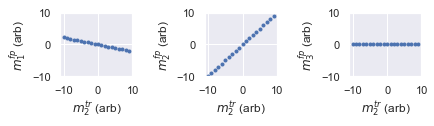

In [4]:
# Plotting parameters (maybe define standard functions based on these reqs later?)
probes = 6

As = np.arange(-10,10)
tr_out = np.empty((len(As),probes))
tr_out[:] = np.nan
fp_out = np.empty((len(As),probes))
fp_out[:] = np.nan

for jj in np.arange(len(As)):
    A = As[jj]
    B_tr = multipole(1, 0, A, tr_x, tr_y)
    B_fp = multipole(1, 0, A, fp6_x_2, fp6_y)

    tr_out[jj,:] = np.matmul(THETA_TR, B_tr)[0:probes]
    fp_out[jj,:] = np.matmul(trfp.THETA_FP_6, B_fp)
    
fig, ax = plt.subplots(1,3)
plt.sca(ax[0])
plt.plot(tr_out[:,1], fp_out[:,0], '.')
plt_set_labels(ax[0], '$m^{tr}_2$ (arb)', '$m^{fp}_1$ (arb)', '')

plt.sca(ax[1])
plt.plot(tr_out[:,1], fp_out[:,1], '.')
plt_set_labels(ax[1], '$m^{tr}_2$ (arb)', '$m^{fp}_2$ (arb)', '')

plt.sca(ax[2])
plt.plot(tr_out[:,1], fp_out[:,2], '.')
plt_set_labels(ax[2], '$m^{tr}_2$ (arb)', '$m^{fp}_3$ (arb)', '')

ax[0].set_ylim((-10,10))
ax[1].set_ylim((-10,10))
ax[2].set_ylim((-10,10))



fig.set_size_inches((6.202,3.833/2))
fig.tight_layout()
# fig.savefig('jacobian_calc.png', dpi=600)

In [5]:
j_6_offset = trfp.J_6_PROBE_OFFSET
j_6 = trfp.J_6_PROBE
j_4 = trfp.J_4_PROBE

output = np.round(j_6_offset,2)
# output[0,1] = 0.0
# output[0,2] = 0.0
# output[1,4] = 0.0
# output[2,3] = 0.0
# output[3,1] = 0.0
# output[3,2] = 0.0
# output[4,2] = 0.0

output[1,3] = 0.0
output[2,1] = 0.0
output[3,2] = 0.0
output[4,1] = 0.0


step2 = [map(str,line) for line in output]
step3 = []
for line in step2:
    new_line = []
    for entry in line:
        new_line.append(entry.rstrip('0').rstrip('.'))
    step3.append(new_line)

print "\\\\\n".join([" & ".join(map(str,line)) for line in step3])

1 & 0.22 & 0 & 0 & 1.34\\
0 & 1 & 0 & 0 & 0.22\\
0 & 0 & 1 & 0.22 & 0\\
0 & 0 & 0 & 0.5 & 0\\
0 & 0 & 0 & 0 & 0.5


In [6]:
theta_4 = trfp.THETA_FP_4
theta_6 = trfp.THETA_FP_6
theta_tr = trfp.THETA_TR

output = np.round(theta_tr,2)

step2 = [map(str,line) for line in output]
step3 = []
for line in step2:
    new_line = []
    for entry in line:
        if float(entry) == 0.0:
            new_line.append(entry.rstrip('0').rstrip('.').lstrip('-'))
        else:
            new_line.append(entry.rstrip('0').rstrip('.'))
    step3.append(new_line)

print "\\\\\n".join([" & ".join(map(str,line)) for line in step3])

0.08 & 0 & 0 & 0 & 0 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08 & 0.08\\
0 & 0 & 0 & 0 & 0 & 0 & 0.11 & 0.19 & 0.21 & 0.19 & 0.11 & 0 & -0.11 & -0.19 & -0.21 & -0.19 & -0.11\\
0 & 0 & 0 & 0 & 0 & -0.21 & -0.19 & -0.11 & 0 & 0.11 & 0.19 & 0.21 & 0.19 & 0.11 & 0 & -0.11 & -0.19\\
0 & 0 & 0 & 0 & 0 & 0 & -0.24 & -0.24 & 0 & 0.24 & 0.24 & 0 & -0.24 & -0.24 & 0 & 0.24 & 0.24\\
0 & -0.07 & 0.07 & -0.07 & 0.07 & -0.26 & -0.13 & 0.13 & 0.26 & 0.13 & -0.13 & -0.26 & -0.13 & 0.13 & 0.26 & 0.13 & -0.13\\
0 & 0 & 0 & 0 & 0 & 0 & -0.35 & 0 & 0.35 & 0 & -0.35 & 0 & 0.35 & 0 & -0.35 & 0 & 0.35\\
0 & 0 & 0 & 0 & 0 & 0.35 & 0 & -0.35 & 0 & 0.35 & 0 & -0.35 & 0 & 0.35 & 0 & -0.35 & 0\\
-3.59 & 11.66 & 11.66 & 11.66 & 11.66 & -3.62 & -3.57 & -3.57 & -3.62 & -3.57 & -3.57 & -3.62 & -3.57 & -3.57 & -3.62 & -3.57 & -3.57\\
0 & 0 & 0 & 0 & 0 & 0 & 0.35 & -0.35 & 0 & 0.35 & -0.35 & 0 & 0.35 & -0.35 & 0 & 0.35 & -0.35\\
0 & 0 & 74.95 & 0 & -74.95 & 0 & -3.22 & -10.65 & -15.81 

In [7]:
# look at fp vs tr (tr is good proxy for actual at low m)

probes = 6
offset = False

dfp_dtr = jacobian_calc(probes, offset)

print np.round(dfp_dtr, 3)
print np.round(np.linalg.inv(dfp_dtr), 3)
# print np.round(np.linalg.pinv(dfp_dtr[0:5,0:5]), 3)
# print np.round(np.matmul(np.linalg.pinv(dfp_dtr[0:5,0:5]),
#                          dfp_dtr[0:5,0:5]
#                         ),
#                3)
        


[[ 1.    -0.    -0.    -0.    -2.632]
 [ 0.     1.     0.     0.     0.   ]
 [ 0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     2.     0.   ]
 [ 0.     0.    -0.     0.     2.   ]]
[[ 1.     0.     0.    -0.     1.316]
 [ 0.     1.     0.     0.     0.   ]
 [ 0.     0.     1.     0.     0.   ]
 [ 0.    -0.     0.     0.5    0.   ]
 [ 0.    -0.     0.    -0.     0.5  ]]


In [8]:
# test Jacobian

probes = 6
offset = True

J_6_probe = trfp.J_6_PROBE
J_6_probe_offset = trfp.J_6_PROBE_OFFSET
J_4_probe = trfp.J_4_PROBE

# print np.round(dfp_dtr, 3)
print np.round(J_4_probe, 3)

B_tr = multipole(1, 1, 4.7, tr_x, tr_y) + multipole(2, 1, -1.35, tr_x, tr_y)
B_fp = multipole(1, 1, 4.7, fp4_x, fp4_y) + multipole(2, 1, -1.35, fp4_x, fp4_y)

m_tr = np.matmul(THETA_TR, B_tr)
m_fp = np.matmul(THETA_FP_4, B_fp)

print np.round(m_tr[0:4], 3)
print np.round(m_fp, 3)

print np.round(np.matmul(J_4_probe, m_fp), 3)

[[ 1.     0.     0.     0.   ]
 [-0.    -0.    -0.    -1.711]
 [ 0.    -0.195  1.     0.   ]
 [ 0.     0.292  0.     0.   ]]
[ 0.    0.    4.7  -1.35]
[ 0.   0.   3.8 -2.7]
[0.   4.62 3.8  0.  ]
